In [44]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.dictionary_based import MUSE
from sktime.transformations.series.sax import SAX
from sktime.transformations.series.paa import PAA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, LeakyReLU, MaxPooling1D, AveragePooling1D
from keras.layers import Activation, Conv1D, BatchNormalization
from sktime.classification.deep_learning import CNNClassifier
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from minisom import MiniSom
import math

In [2]:
def load_npy(filename):
    return np.load(filename)


dir_path = "../cleaned_time_series/"
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)
X_train = []
for i in range(len(X)):
    serie = pd.Series(X[i,-1].T)
    X_train.append(serie)
X_df = pd.DataFrame(X_train)
Y_df = pd.DataFrame()
Y_df['genre'] = y

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2, random_state=42, stratify=y)

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
X_train_cnn = X_train_scaled.copy()
X_test_cnn = X_test_scaled.copy()

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)


TIMESTEPS:  1280
N. LABELS:  20


In [6]:
y_train_cnn = y_train['genre'].astype('category').cat.codes
category_mapping_train = y_train['genre'].astype('category').cat.categories

y_test_cnn = y_test['genre'].astype('category').cat.codes
category_mapping_test = y_test['genre'].astype('category').cat.categories

# NEURAL NETWORKS

MODIFIED MODEL: 
- MODIFICA DELLA FUNZIONE DI ATTIVAZIONE DA RELU A LEAKY RELU PER PREVENIRE IL DYING RELU PROBLEM
- SOFTMAX come output layer per multi class problem
- Dropout da 0.3 a 0.2
- Learning rate da 0.0001 a 0.001
- Weight initialization con he_normal
- 


In [71]:
def build_specific_modified_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(Conv1D(filters=16, kernel_size=8, input_shape=(n_timesteps, 1), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(AveragePooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(AveragePooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="softmax", kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer= keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )

    return model

Epoch 1/150
200/200 [==============================] - 5s 22ms/step - loss: 2.8975 - accuracy: 0.1256 - val_loss: 2.7691 - val_accuracy: 0.1437
Epoch 2/150
200/200 [==============================] - 5s 26ms/step - loss: 2.6946 - accuracy: 0.1911 - val_loss: 2.6664 - val_accuracy: 0.1925
Epoch 3/150
200/200 [==============================] - 5s 26ms/step - loss: 2.5959 - accuracy: 0.2222 - val_loss: 2.5862 - val_accuracy: 0.2250
Epoch 4/150
200/200 [==============================] - 5s 24ms/step - loss: 2.5236 - accuracy: 0.2539 - val_loss: 2.5034 - val_accuracy: 0.2350
Epoch 5/150
200/200 [==============================] - 5s 24ms/step - loss: 2.4706 - accuracy: 0.2670 - val_loss: 2.4253 - val_accuracy: 0.2750
Epoch 6/150
200/200 [==============================] - 5s 24ms/step - loss: 2.4170 - accuracy: 0.2828 - val_loss: 2.3948 - val_accuracy: 0.2781
Epoch 7/150
200/200 [==============================] - 5s 24ms/step - loss: 2.3795 - accuracy: 0.2900 - val_loss: 2.3515 - val_accuracy:

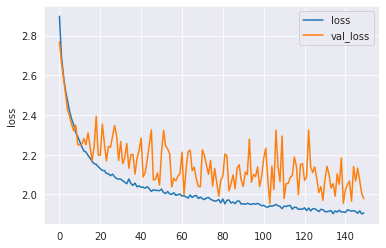

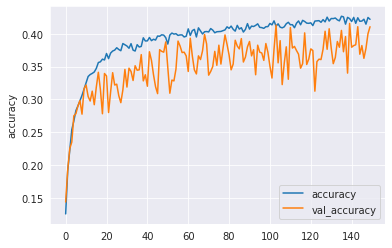

In [72]:
cnn_modified = build_specific_modified_cnn(n_timesteps, n_outputs)
es = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True)
callbacks = [es]

cnn_modified.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    validation_split=0.2,
)
summary = pd.DataFrame(cnn_modified.history.history)
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [73]:
y_pred = cnn_modified.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)

y_test_original = category_mapping_test[y_test_cnn]
y_pred_original = category_mapping_test[y_pred]

# Generate and print the classification report using the original labels
report = classification_report(y_test_original, y_pred_original, target_names=category_mapping_test, zero_division=0)
print(report)


63/63 [==============================] - 0s 5ms/step
                   precision    recall  f1-score   support

              emo       0.47      0.20      0.28       100
             folk       0.50      0.01      0.02       100
             goth       0.23      0.03      0.05       100
            happy       0.72      0.67      0.69       100
      heavy-metal       0.36      0.74      0.49       100
       honky-tonk       0.35      0.56      0.43       100
           j-idol       0.33      0.64      0.44       100
             kids       0.62      0.05      0.09       100
   minimal-techno       0.53      0.68      0.60       100
              mpb       0.17      0.38      0.23       100
          new-age       0.39      0.50      0.44       100
            opera       0.34      0.64      0.44       100
            piano       0.72      0.18      0.29       100
progressive-house       0.55      0.32      0.41       100
            salsa       0.78      0.62      0.69       100
  

63/63 [==============================] - 0s 3ms/step


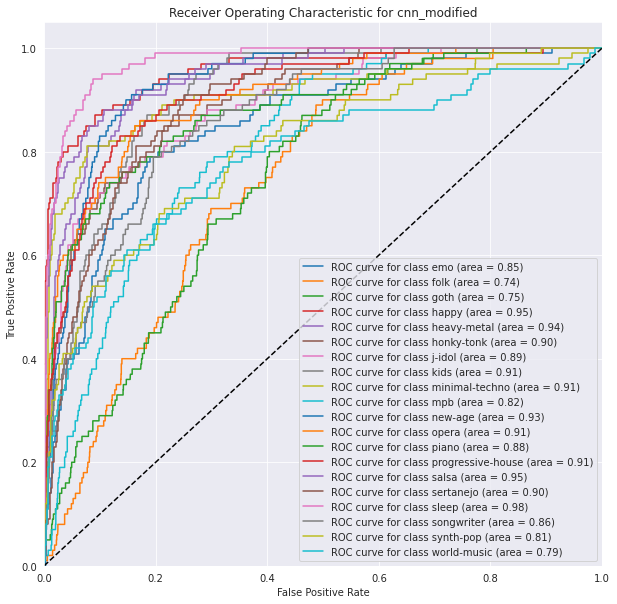

In [74]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarize the labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_cnn)

# Predict the probabilities for each class
y_pred_prob = cnn_modified.predict(X_test_cnn)

# Compute and plot the ROC curves
plt.figure(figsize=(10, 10))
for i, class_ in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve for class {} (area = {:.2f})'.format(category_mapping_test[class_], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for cnn_modified')
plt.legend(loc="lower right")
plt.show()

# RES-NET

In [53]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, LeakyReLU, Dropout, GlobalAveragePooling1D, Dense, Add
from keras.initializers import HeNormal
from keras.optimizers import SGD

def residual_block(x, filters, kernel_size):
    shortcut = x

    # First convolutional layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Second convolutional layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Third convolutional layer
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)

    # Use 1x1 convolution to match the dimensions of the shortcut to the output
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same', kernel_initializer=HeNormal())(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut connection
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.01)(x)
    return x

def build_resnet(n_timesteps, n_outputs):
    inputs = Input(shape=(n_timesteps, 1))

    # Initial convolutional layer
    x = Conv1D(filters=16, kernel_size=8, padding='same', kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)

    # First residual block
    x = residual_block(x, filters=16, kernel_size=8)

    # Second residual block
    x = residual_block(x, filters=32, kernel_size=5)

    # Third residual block
    x = residual_block(x, filters=64, kernel_size=3)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Output layer
    outputs = Dense(n_outputs, activation='softmax', kernel_initializer=HeNormal())(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with SGD optimizer and momentum
    sgd = SGD(learning_rate=0.0001, momentum=0.9)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'],
    )

    return model


In [ ]:
res_net = build_resnet(n_timesteps, n_outputs)
res_net.summary()

Epoch 1/50
175/175 [==============================] - 34s 197ms/step - loss: 3.0776 - accuracy: 0.0498 - val_loss: 3.0602 - val_accuracy: 0.0504
Epoch 2/50
175/175 [==============================] - 33s 189ms/step - loss: 3.0365 - accuracy: 0.0512 - val_loss: 3.0282 - val_accuracy: 0.0558
Epoch 3/50
175/175 [==============================] - 35s 202ms/step - loss: 3.0057 - accuracy: 0.0613 - val_loss: 3.0004 - val_accuracy: 0.0667
Epoch 4/50
175/175 [==============================] - 31s 176ms/step - loss: 2.9832 - accuracy: 0.0686 - val_loss: 2.9781 - val_accuracy: 0.0771
Epoch 5/50
175/175 [==============================] - 33s 186ms/step - loss: 2.9649 - accuracy: 0.0737 - val_loss: 2.9607 - val_accuracy: 0.0838
Epoch 6/50
175/175 [==============================] - 35s 200ms/step - loss: 2.9512 - accuracy: 0.0829 - val_loss: 2.9463 - val_accuracy: 0.0867
Epoch 7/50
175/175 [==============================] - 31s 179ms/step - loss: 2.9386 - accuracy: 0.0879 - val_loss: 2.9339 - val_ac

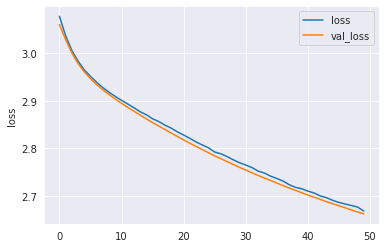

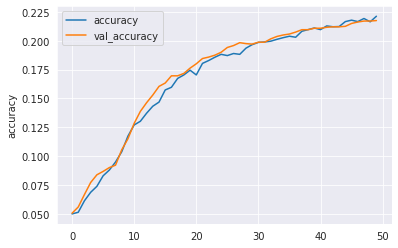

In [58]:
res_net.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=50,
    batch_size=32,
    validation_split=0.3,
)
summary = pd.DataFrame(res_net.history.history)
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [63]:
y_pred = res_net.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)

y_test_original = category_mapping_test[y_test_cnn]
y_pred_original = category_mapping_test[y_pred]

# Generate and print the classification report using the original labels
report = classification_report(y_test_original, y_pred_original, target_names=category_mapping)
print(report)

63/63 [==============================] - 2s 31ms/step
                   precision    recall  f1-score   support

              emo       0.09      0.03      0.04       100
             folk       0.00      0.00      0.00       100
             goth       0.05      0.01      0.02       100
            happy       0.24      0.47      0.32       100
      heavy-metal       0.13      0.28      0.18       100
       honky-tonk       0.06      0.03      0.04       100
           j-idol       0.46      0.12      0.19       100
             kids       0.18      0.13      0.15       100
   minimal-techno       0.28      0.62      0.39       100
              mpb       0.12      0.03      0.05       100
          new-age       0.26      0.65      0.37       100
            opera       0.20      0.44      0.27       100
            piano       0.30      0.06      0.10       100
progressive-house       0.07      0.01      0.02       100
            salsa       0.33      0.65      0.44       100
 

63/63 [==============================] - 2s 30ms/step


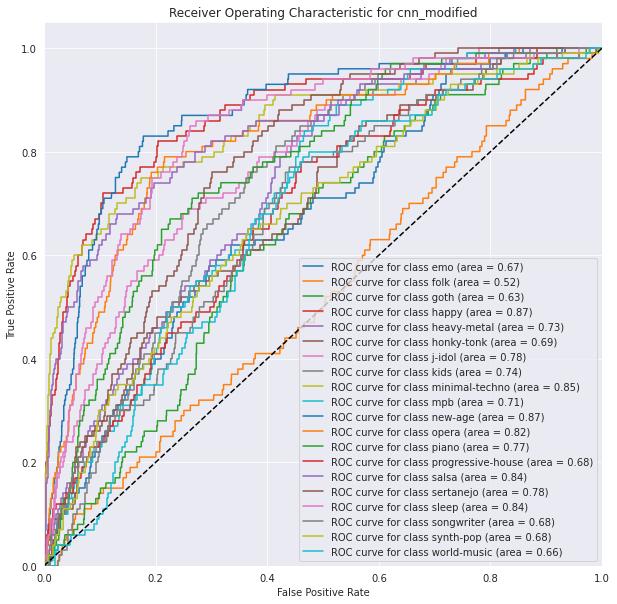

In [64]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarize the labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_cnn)

# Predict the probabilities for each class
y_pred_prob = res_net.predict(X_test_cnn)

# Compute and plot the ROC curves
plt.figure(figsize=(10, 10))
for i, class_ in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve for class {} (area = {:.2f})'.format(category_mapping[class_], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for cnn_modified')
plt.legend(loc="lower right")
plt.show()

# ROCKET

played with n_features from 8 to 128 with step *2 and the accuracy was always the same, keeping n_kernels and dilations fixed to 10000 and 32, this means that n_features is not impacting the accuracy in any way

now playing wit kernels 100, 1000, 10000 and dilation 8, 16, 32 to see if we can get some better accuracies.

In [ ]:
n_kernels = [100, 1000, 10000]
dilations = [8, 16, 32]
reports = []
for n_kernel in n_kernels:
    for dilation in dilations:
        rocket = RocketClassifier(rocket_transform="minirocket", n_jobs=-1, random_state=42, num_kernels=n_kernel, max_dilations_per_kernel=dilation, n_features_per_kernel=n_features)
        rocket.fit(X_train_scaled, y_train)
        report = classification_report(y_test, rocket.predict(X_test_scaled))
        reports.append(report)


In [23]:
# format reports
for i, report in enumerate(reports):
    print(report)

                   precision    recall  f1-score   support

              emo       0.26      0.12      0.16       100
             folk       0.00      0.00      0.00       100
             goth       0.20      0.02      0.04       100
            happy       0.30      0.46      0.37       100
      heavy-metal       0.28      0.61      0.39       100
       honky-tonk       0.31      0.44      0.36       100
           j-idol       0.35      0.34      0.35       100
             kids       0.19      0.08      0.11       100
   minimal-techno       0.30      0.57      0.39       100
              mpb       0.12      0.03      0.05       100
          new-age       0.31      0.51      0.39       100
            opera       0.30      0.58      0.39       100
            piano       0.36      0.23      0.28       100
progressive-house       0.30      0.11      0.16       100
            salsa       0.31      0.69      0.43       100
        sertanejo       0.23      0.37      0.28       

In [7]:
rocket = RocketClassifier(rocket_transform="minirocket", n_jobs=-1, random_state=42, num_kernels=10000)
rocket.fit(X_train_scaled, y_train)
report = classification_report(y_test, rocket.predict(X_test_scaled))
print(report)

                   precision    recall  f1-score   support

              emo       0.34      0.28      0.31       100
             folk       0.15      0.09      0.11       100
             goth       0.08      0.04      0.05       100
            happy       0.71      0.77      0.74       100
      heavy-metal       0.39      0.55      0.46       100
       honky-tonk       0.42      0.50      0.45       100
           j-idol       0.36      0.37      0.36       100
             kids       0.28      0.25      0.26       100
   minimal-techno       0.61      0.67      0.64       100
              mpb       0.19      0.12      0.15       100
          new-age       0.40      0.51      0.45       100
            opera       0.46      0.55      0.50       100
            piano       0.39      0.35      0.37       100
progressive-house       0.48      0.52      0.50       100
            salsa       0.51      0.71      0.60       100
        sertanejo       0.30      0.38      0.34       

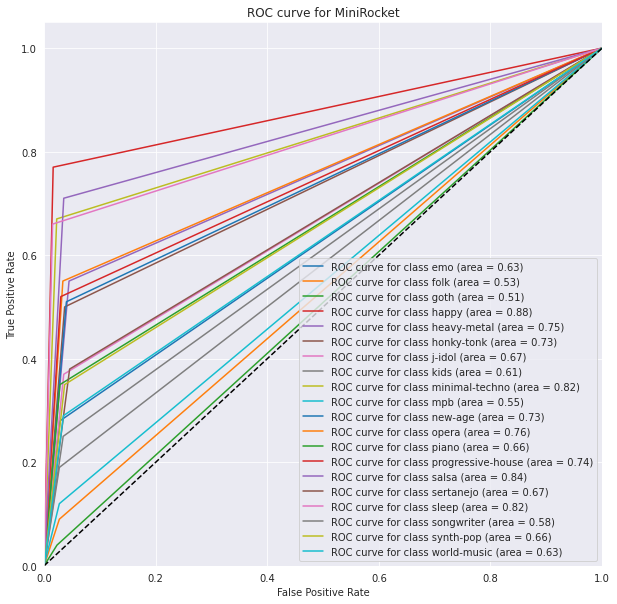

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarize the labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_cnn)

# Predict the probabilities for each class
y_pred_prob = rocket.predict_proba(X_test_cnn)

# Compute and plot the ROC curves
plt.figure(figsize=(10, 10))
for i, class_ in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve for class {} (area = {:.2f})'.format(category_mapping_test[class_], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for MiniRocket')
plt.legend(loc="lower right")
plt.show()